
--- BASIC INFO ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1461 entries, 0 to 1460
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Date_Time       1461 non-null   datetime64[ns]
 1   Temp_C          1461 non-null   float64       
 2   Humidity_%      1461 non-null   int64         
 3   Wind_Speed_kmh  1461 non-null   float64       
 4   Pressure_hPa    1461 non-null   float64       
 5   US_AQI          1461 non-null   int64         
 6   PM2.5_ugm3      1461 non-null   float64       
 7   PM10_ugm3       1461 non-null   float64       
 8   NO2_ugm3        1461 non-null   float64       
 9   CO_ugm3         1461 non-null   int64         
 10  SO2_ugm3        1461 non-null   float64       
 11  O3_ugm3         1461 non-null   int64         
dtypes: datetime64[ns](1), float64(7), int64(4)
memory usage: 137.1 KB
None

--- MISSING VALUES ---
Date_Time         0
Temp_C            0
Humid

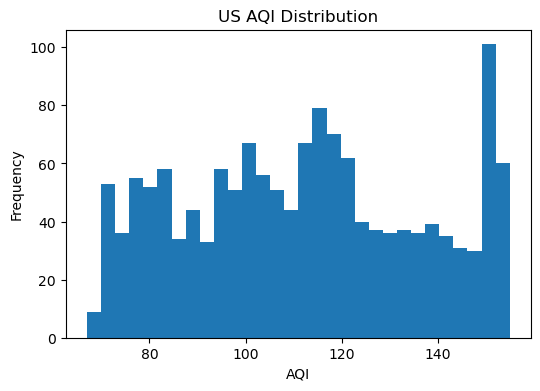

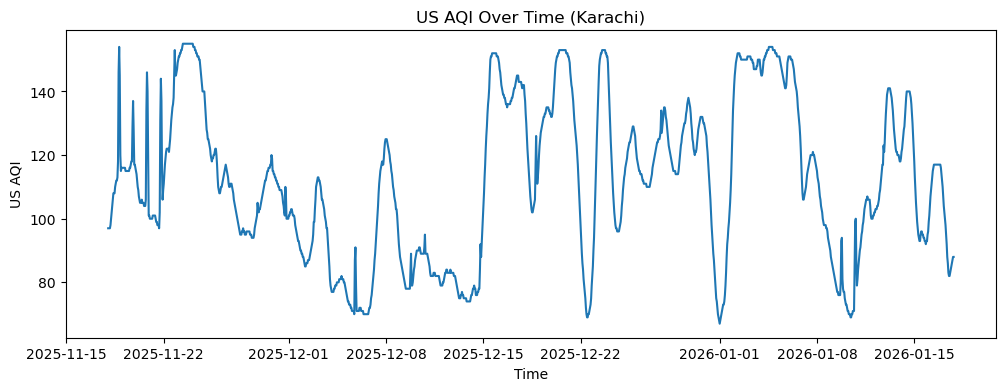

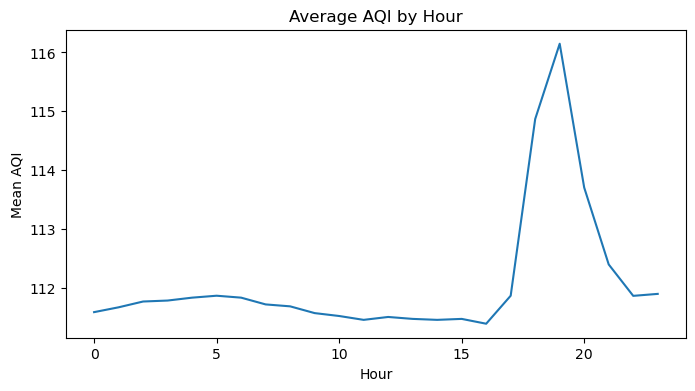

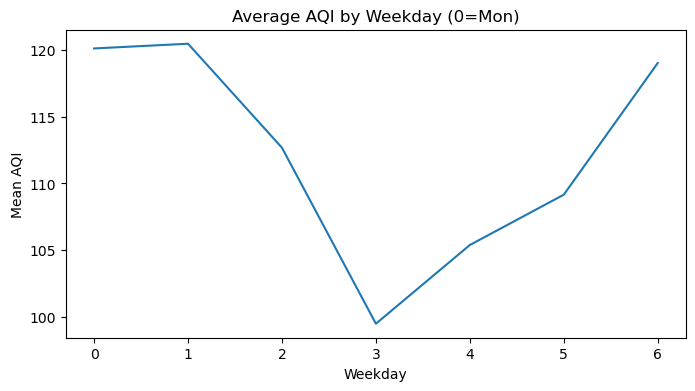

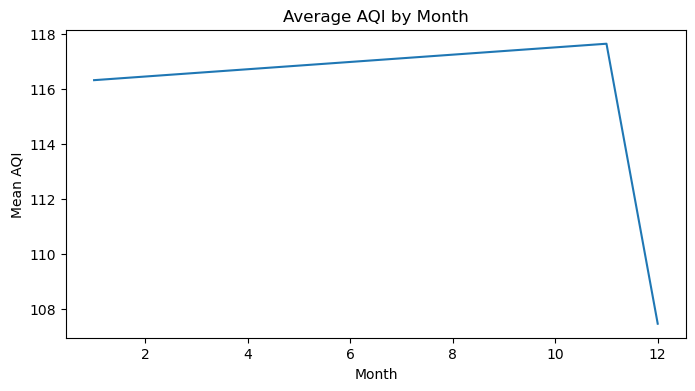

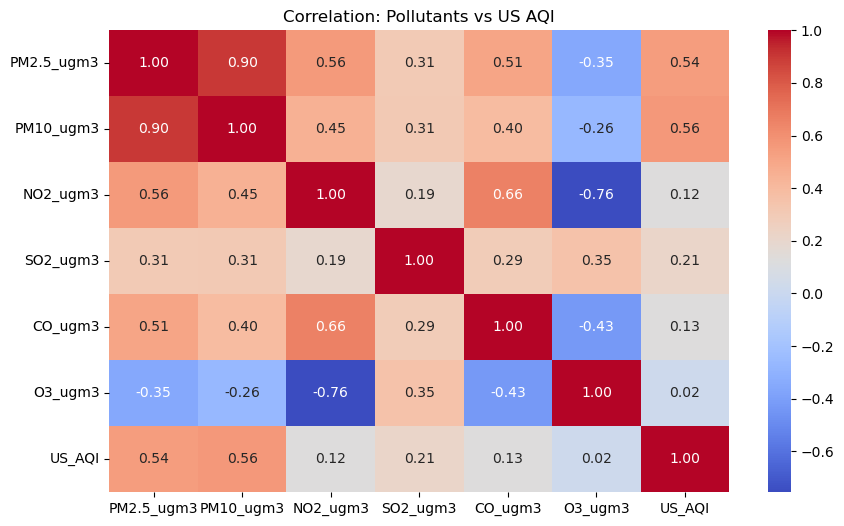

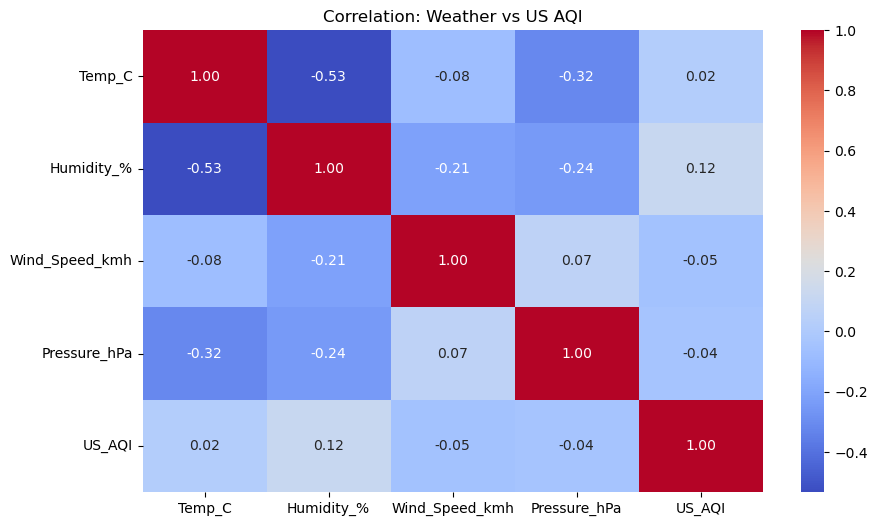


--- AQI LAG CORRELATION ---
              US_AQI  aqi_lag_1  aqi_lag_3  aqi_lag_24
US_AQI      1.000000   0.993298   0.965210    0.478316
aqi_lag_1   0.993298   1.000000   0.979728    0.496654
aqi_lag_3   0.965210   0.979728   1.000000    0.534545
aqi_lag_24  0.478316   0.496654   0.534545    1.000000


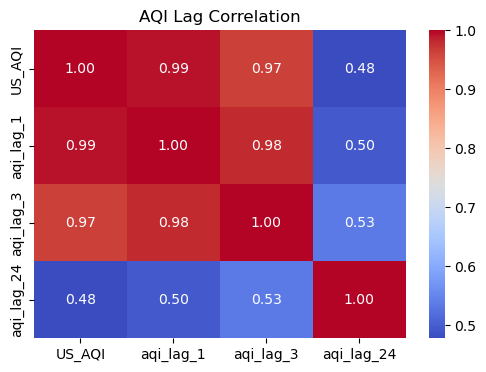

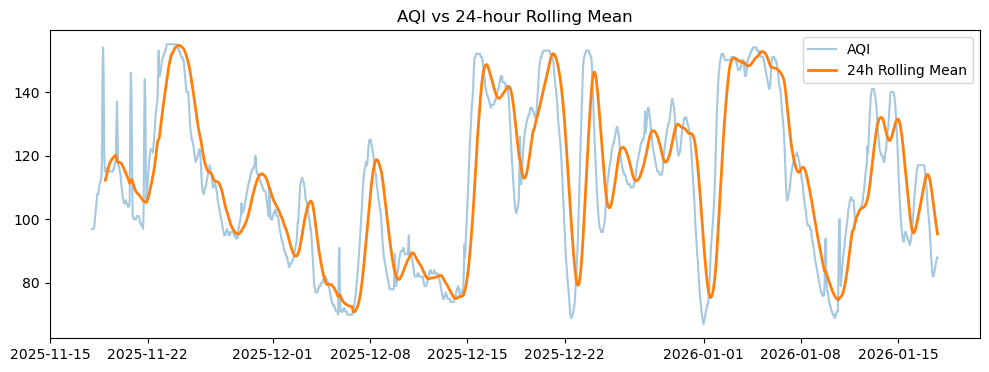


EDA SUMMARY FOR FEATURE ENGINEERING
----------------------------------
1. AQI shows strong temporal dependency → lag features required
2. PM2.5 and PM10 show strongest correlation → priority features
3. Wind speed & pressure inversely correlated → useful predictors
4. Clear hourly & seasonal patterns → time-based features required
5. AQI is numeric (0–500) → regression problem



In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ==============================
# LOAD DATA
# ==============================
df = pd.read_csv("karachi_actual_historical_data.csv")

df["Date_Time"] = pd.to_datetime(df["Date_Time"])
df = df.sort_values("Date_Time")

print("\n--- BASIC INFO ---")
print(df.info())

print("\n--- MISSING VALUES ---")
print(df.isna().sum())

print("\n--- BASIC STATISTICS ---")
print(df.describe())

# ==============================
# TARGET (AQI) ANALYSIS
# ==============================
plt.figure(figsize=(6,4))
df["US_AQI"].plot(kind="hist", bins=30)
plt.title("US AQI Distribution")
plt.xlabel("AQI")
plt.ylabel("Frequency")
plt.show()

plt.figure(figsize=(12,4))
plt.plot(df["Date_Time"], df["US_AQI"])
plt.title("US AQI Over Time (Karachi)")
plt.xlabel("Time")
plt.ylabel("US AQI")
plt.show()

# ==============================
# TIME-BASED PATTERNS (KEY FOR FEATURES)
# ==============================
df["hour"] = df["Date_Time"].dt.hour
df["weekday"] = df["Date_Time"].dt.weekday
df["month"] = df["Date_Time"].dt.month

plt.figure(figsize=(8,4))
df.groupby("hour")["US_AQI"].mean().plot()
plt.title("Average AQI by Hour")
plt.xlabel("Hour")
plt.ylabel("Mean AQI")
plt.show()

plt.figure(figsize=(8,4))
df.groupby("weekday")["US_AQI"].mean().plot()
plt.title("Average AQI by Weekday (0=Mon)")
plt.xlabel("Weekday")
plt.ylabel("Mean AQI")
plt.show()

plt.figure(figsize=(8,4))
df.groupby("month")["US_AQI"].mean().plot()
plt.title("Average AQI by Month")
plt.xlabel("Month")
plt.ylabel("Mean AQI")
plt.show()

# ==============================
# POLLUTANT RELATIONSHIP (MOST IMPORTANT)
# ==============================
pollutants = [
    "PM2.5_ugm3", "PM10_ugm3",
    "NO2_ugm3", "SO2_ugm3",
    "CO_ugm3", "O3_ugm3"
]

plt.figure(figsize=(10,6))
sns.heatmap(
    df[pollutants + ["US_AQI"]].corr(),
    annot=True,
    cmap="coolwarm",
    fmt=".2f"
)
plt.title("Correlation: Pollutants vs US AQI")
plt.show()

# ==============================
# WEATHER RELATIONSHIP
# ==============================
weather = ["Temp_C", "Humidity_%", "Wind_Speed_kmh", "Pressure_hPa"]

plt.figure(figsize=(10,6))
sns.heatmap(
    df[weather + ["US_AQI"]].corr(),
    annot=True,
    cmap="coolwarm",
    fmt=".2f"
)
plt.title("Correlation: Weather vs US AQI")
plt.show()

# ==============================
# TEMPORAL DEPENDENCY (LAG CHECK)
# ==============================
df["aqi_lag_1"] = df["US_AQI"].shift(1)
df["aqi_lag_3"] = df["US_AQI"].shift(3)
df["aqi_lag_24"] = df["US_AQI"].shift(24)

lag_corr = df[
    ["US_AQI", "aqi_lag_1", "aqi_lag_3", "aqi_lag_24"]
].corr()

print("\n--- AQI LAG CORRELATION ---")
print(lag_corr)

plt.figure(figsize=(6,4))
sns.heatmap(lag_corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("AQI Lag Correlation")
plt.show()

# ==============================
# ROLLING TREND CHECK
# ==============================
df["aqi_roll_24"] = df["US_AQI"].rolling(24).mean()

plt.figure(figsize=(12,4))
plt.plot(df["Date_Time"], df["US_AQI"], label="AQI", alpha=0.4)
plt.plot(df["Date_Time"], df["aqi_roll_24"], label="24h Rolling Mean", linewidth=2)
plt.legend()
plt.title("AQI vs 24-hour Rolling Mean")
plt.show()

# ==============================
# FINAL EDA SUMMARY (PRINTED)
# ==============================
print("""
EDA SUMMARY FOR FEATURE ENGINEERING
----------------------------------
1. AQI shows strong temporal dependency → lag features required
2. PM2.5 and PM10 show strongest correlation → priority features
3. Wind speed & pressure inversely correlated → useful predictors
4. Clear hourly & seasonal patterns → time-based features required
5. AQI is numeric (0–500) → regression problem
""")
